# Hyperparameter optimization with Bayesian Optimization

Imports and stuff:

In [1]:
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm

from src.dl.resnet import CustomLayerConfig
from src.bayesian_optim.bayesian_optimizer import BayesianOptimizer
from src.dl.trainer import FashionMNISTTrainer, Hyperparameters
from src.dl.resnet import CustomResNet

/home/andrebw/repos/bayesian-hyperparameter-optimization/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup the ResNet model and the trainer.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {device}")

layer_cfg = CustomLayerConfig(  # use a slighly bigger model than default
    l0_dim=16,
    l1_dim=16,
    l2_dim=32,
    l3_dim=32,
    l4_dim=64,
    l5_dim=64,
)
model = CustomResNet(layer_cfg=layer_cfg)
trainer = FashionMNISTTrainer(model=model, device=device, use_tqdm=False)  # disable tqdm because it has some weird behavior in notebooks

Using device: cpu


Define the objective function. Here, the objective is the accuracy of the model given the input learning rate.

In [3]:
# Set the other hyperparameters
epochs = 10  # train for 10 epochs
batch_size = 128

def objective(
    lr: torch.Tensor,
):
    torch.manual_seed(0)  # reproducibility across training runs
    hyperparams = Hyperparameters(
        epochs=epochs,
        learning_rate=lr.item(),
        batch_size=batch_size,
    )
    # Train, test and return the accuracy of the ResNet model
    return (
        trainer.train_and_test(hparams=hyperparams)
        .unsqueeze(0)
        .detach()
        .cpu()
        .double()
    )

Define the Bayesian Optimizer and start optimizing.

In [4]:
initial_steps = 3  # we initialize with three random samples
optimization_steps = 7  # optimize for 7 steps

optimizer = BayesianOptimizer(objective_f=objective)  # pass the objective function we just created
optimizer.initialize(initial_steps)

Optimization steps:   0%|          | 0/7 [00:00<?, ?it/s]

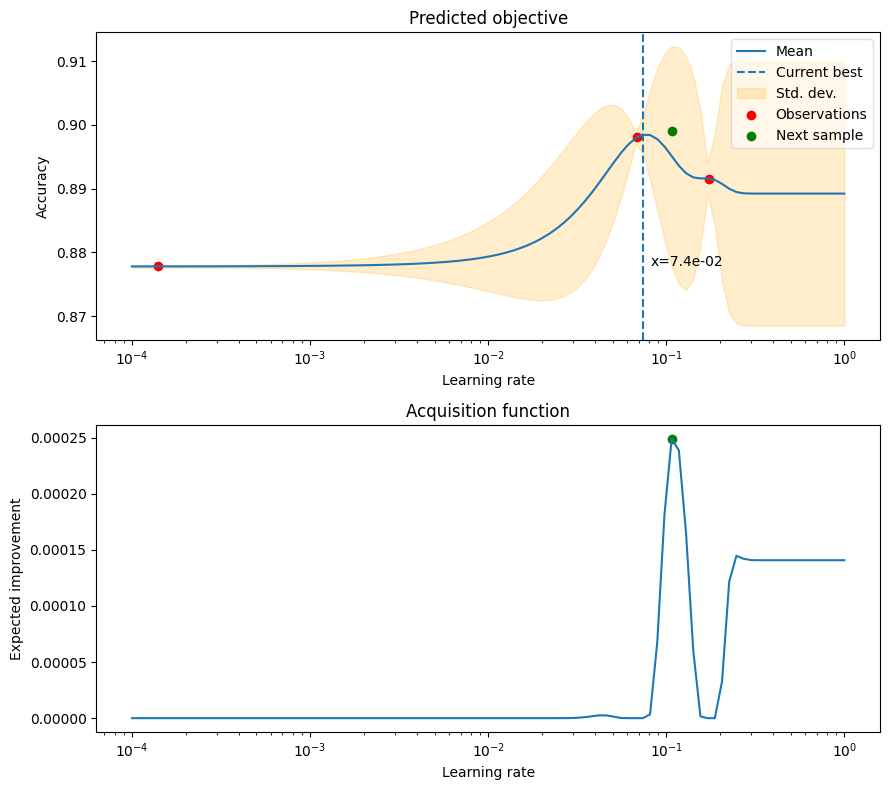

Optimization steps:  14%|█▍        | 1/7 [02:12<13:15, 132.60s/it]

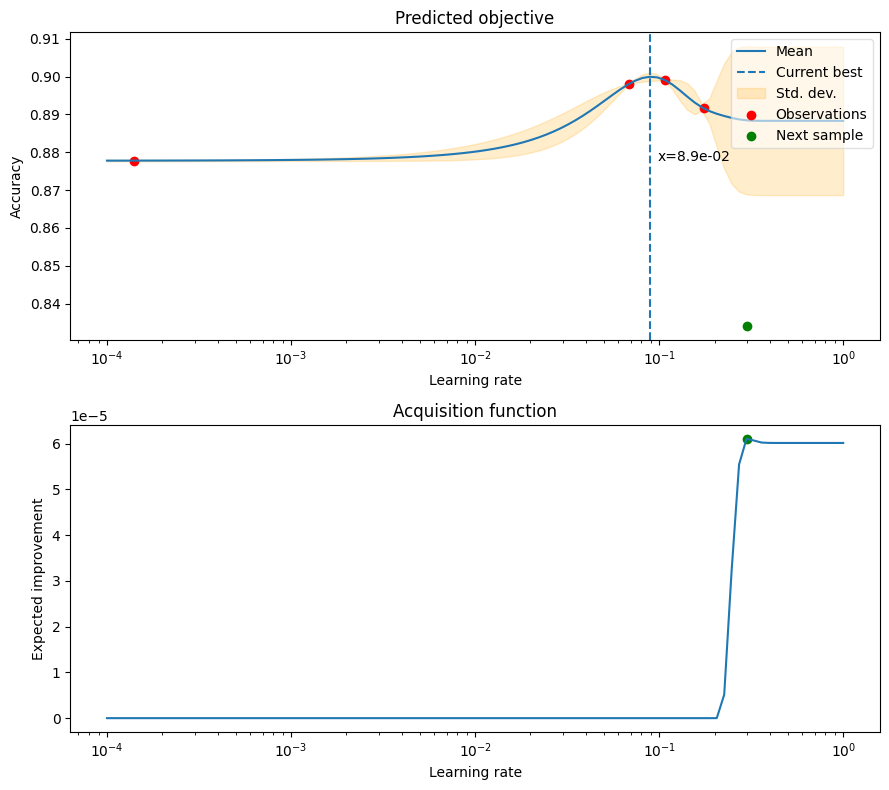

Optimization steps:  29%|██▊       | 2/7 [04:31<11:22, 136.46s/it]

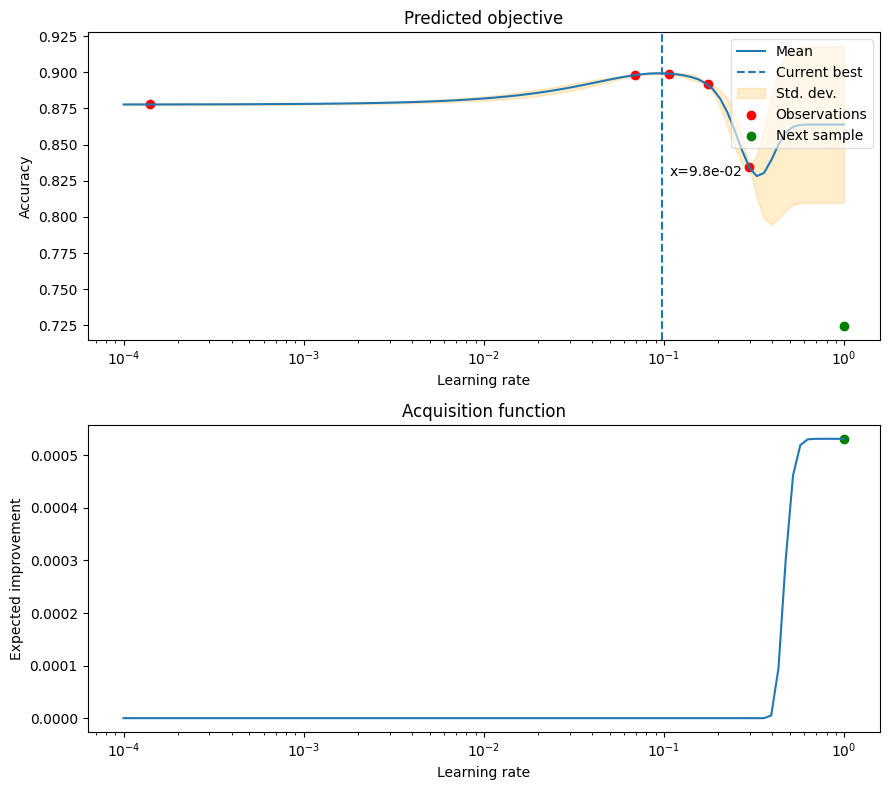

Optimization steps:  43%|████▎     | 3/7 [06:49<09:08, 137.05s/it]

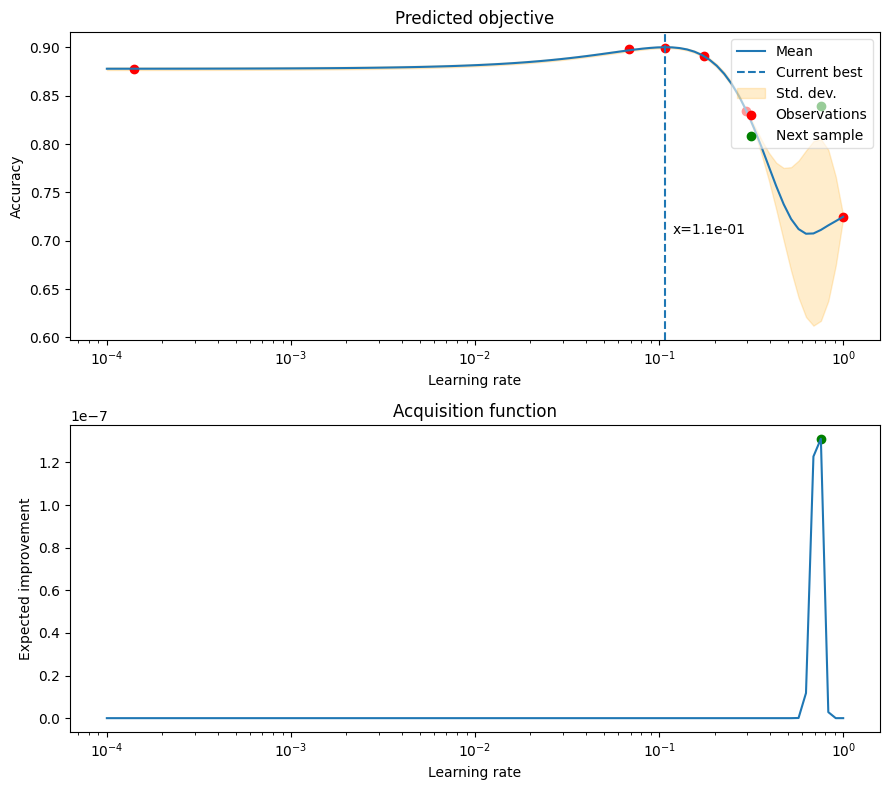

Optimization steps:  57%|█████▋    | 4/7 [09:07<06:52, 137.50s/it]

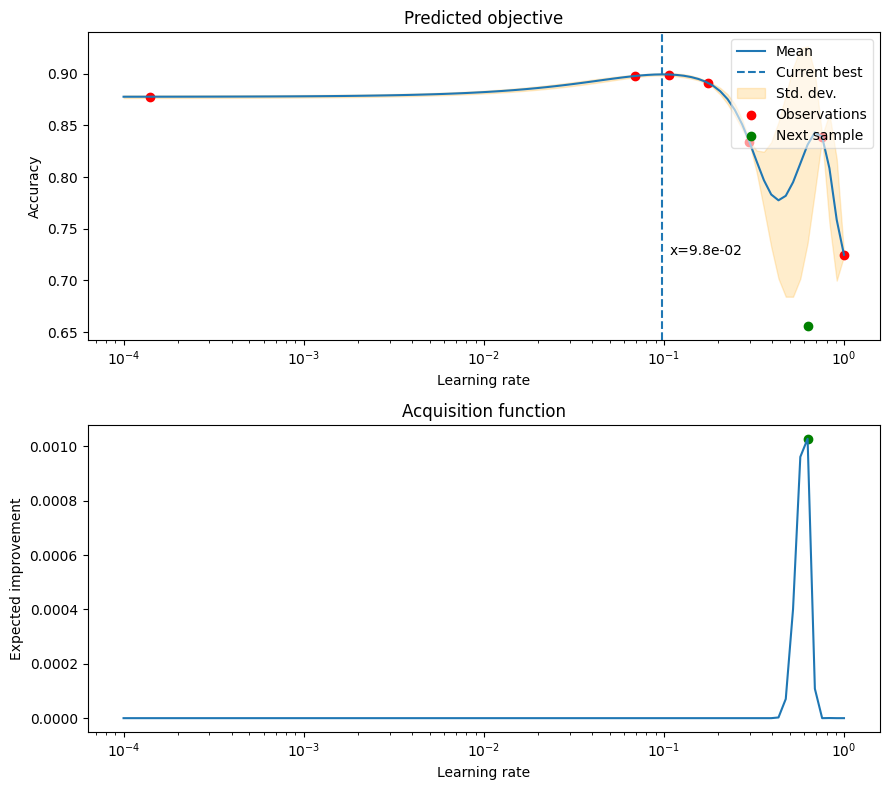

Optimization steps:  71%|███████▏  | 5/7 [11:32<04:39, 139.97s/it]

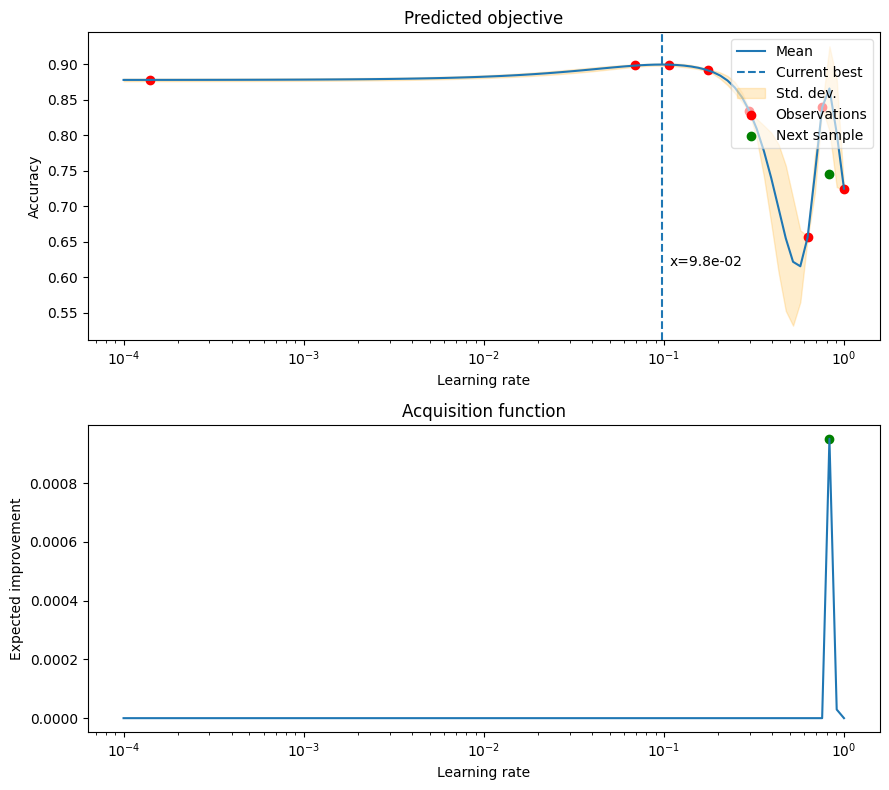

Optimization steps:  86%|████████▌ | 6/7 [13:50<02:19, 139.38s/it]

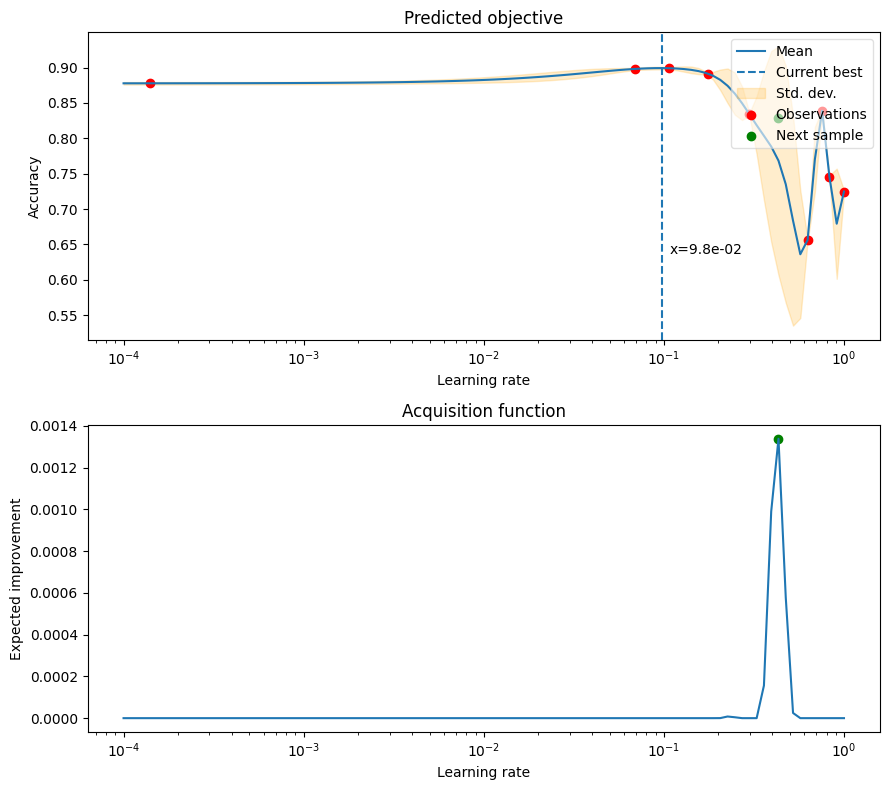

Optimization steps: 100%|██████████| 7/7 [16:06<00:00, 138.01s/it]


In [5]:
# Optimize using Gaussian Process and Expected Improvement acquisition
for i in tqdm(range(optimization_steps), desc="Optimization steps"):
    mean, std, ei = optimizer.step()
    fig = optimizer.visualize(mean, std, ei)
    plt.show()

In [6]:
# Get the current best learning rate. 
# Here, we just get the maximum of the mean of the posterior. 
# Alternatively we could get the next EI, but that would include exploration, which we don't want for the final prediction.
best_x, best_y = optimizer.get_current_max_point(mean)
print(
    "Optimization completed!\n"
    f"Estimated best learning rate is {best_x:.3f} with an accuracy of {best_y*100:.2f} %."
)

Optimization completed!
Estimated best learning rate is 0.098 with an accuracy of 89.93 %.
